# Real-NVP: conditional normalizing flows

![real-nvp-generative](imgs/real-nvp-generative-results.png)

### Q: What are the samples here? What is the dimensionality of the parameter space? 

### Q: How to control the content of generated images?

# Conditional moons

![conditional-flows](imgs/conditional-flows-slide.png)

In [ ]:
import torch
from torch import nn, Tensor
from torch.nn import functional as F


import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
def sample_moons_with_context(n_samples: int, noise: float = 0.1) -> Tensor:
    """
    Sample a moons dataset using scikit-learn.
    :param n_samples: The number of samples to generate.
    :param noise: The standard deviation of the Gaussian noise added to the data.
    :return: A tensor of shape (n_samples, 2) containing the samples.
    """
    from sklearn.datasets import make_moons

    # draw samples from the training distribution
    moon_samples, labels = make_moons(n_samples=n_samples, noise=noise)
    
    x = torch.tensor(moon_samples).float()
    context = torch.tensor(labels)[..., None].float()

    return x, context

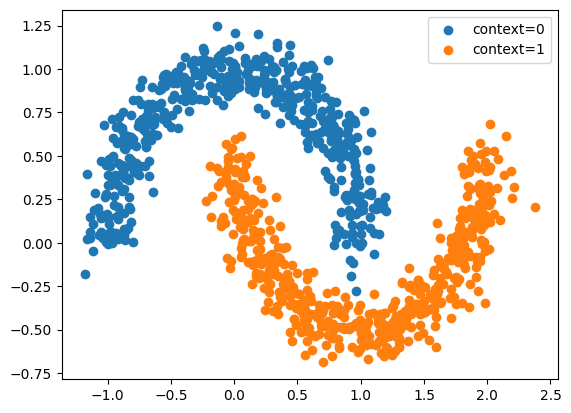

In [21]:
samples, context = sample_moons_conditioned(1000)

plt.scatter(*samples[context.flatten()==0].cpu().numpy().T, label='context=0')
plt.scatter(*samples[context.flatten()==1].cpu().numpy().T, label='context=1')
plt.legend()

# Add context to normalizing flows

### Old MLP

In [4]:
class MLP(nn.Module):
    """
    A simple multi-layer perceptron.
    """
    def __init__(self, in_dim: int, hid_dims: tuple[int, ...], out_dim: int, activation=F.leaky_relu, apply_last_act: bool = False):
        super(MLP, self).__init__()

        in_dims = [in_dim] + list(hid_dims)
        out_dims = list(hid_dims) + [out_dim]

        self.linear_layers = nn.ModuleList([
            nn.Linear(in_dim, hid_dim)
            for in_dim, hid_dim in zip(in_dims, out_dims)
        ])

        self.activation = activation
        self.apply_last_act = apply_last_act

    def forward(self, x: Tensor, context=None) -> Tensor:
        for layer in self.linear_layers[:-1]:
            x = layer(x)
            x = self.activation(x)

        x = self.linear_layers[-1](x)

        if self.apply_last_act:
            x = self.activation(x)
        return x

### MLP with optional context

In [5]:
class MLPWithContext(MLP):
    def forward(self, x: Tensor, context: Tensor = None):
        if context is not None:
            x = torch.cat([x, context], dim=-1)
        return super().forward(x)

### Transforms with context

In [6]:
class Transform(nn.Module):
    """Base class for all transform objects."""

    def forward(self, x: Tensor, context: Tensor = None) -> tuple[Tensor, Tensor]:
        """
        Forward pass of the transform.
        :param x: The input tensor.
        :param context: The context tensor.
        :return: A tuple of the output tensor and the log-determinant of the Jacobian.
        """
        raise NotImplementedError()

    def inverse(self, y: Tensor, context: Tensor = None) -> tuple[Tensor, Tensor]:
        """
        Inverse pass of the transform.
        :param y: The input tensor.
        :param context: The context tensor.
        :return: A tuple of the output tensor and the log-determinant of the Jacobian.
        """
        raise NotImplementedError()


class CompositeTransform(Transform):
    """
    A composition of transformations.
    """
    def __init__(self, transforms: list[Transform]):
        super().__init__()

        # Create a list of affine coupling layers
        self.transforms = nn.ModuleList(list(transforms))

    def forward(self, x: Tensor, context: Tensor = None) -> tuple[Tensor, Tensor]:
        """
        Forward pass of the sequence of affine coupling layers.
        :param x: Input tensor of shape (batch_size, num_features
        :param context: The context tensor.
        :return: Transformed tensor and the log-determinant of the Jacobian.
        """
        logdetjac = torch.zeros(x.size(0), device=x.device)

        # Apply each affine coupling layer in the sequence
        for transform in self.transforms:
            x, ldj = transform(x, context)
            logdetjac += ldj

        return x, logdetjac
    
    def inverse(self, y: Tensor, context: Tensor = None) -> tuple[Tensor, Tensor]:
        """
        Inverse pass of the sequence of affine coupling layers.
        :param y: Transformed tensor of shape (batch_size, num_features).
        :param context: The context tensor.
        :return: A tuple of the output tensor and the log-determinant of the Jacobian.
        """
        logdetjac = torch.zeros(y.size(0), device=y.device)

        # Apply each affine coupling layer in the sequence in reverse order
        for transform in reversed(self.transforms):
            y, ldj = transform.inverse(y, context)
            logdetjac += ldj

        return y, logdetjac

In [50]:
class AffineCouplingTransform(Transform):
    """
    An affine coupling transform for Real-NVP.
    """
    def __init__(self, mask: Tensor, hidden_features: int = 16, num_layers: int = 2, context_dim: int = 0):
        """
        Initialize the affine coupling layer.

        :param mask: A boolean tensor that indicates which parameters are transformed by the affine coupling layer.
            True means that the parameter is passed through unchanged (x_{1:d}), False means that it is transformed (x_{d+1:D}).
        :param hidden_features: The number of hidden features in the scale and shift MLP networks. 
        :param num_layers: The number of layers in the scale and shift MLP networks. 
        :context_dim: The dimension of the context tensor.
        """
        super().__init__()

        # The mask used to split the input tensor into two parts
        self.mask = mask

        # The number of parameters that will stay unchanged (d in the paper notation)
        num_unchanged_params: int = mask.sum().item()

        # The number of parameters that will be transformed (D - d in the paper notation)
        num_transformed_params: int = mask.size(0) - num_unchanged_params

        # Define the scale network (MLP) with the given hidden features and number of layers
        self.scale = MLPWithContext(num_unchanged_params + context_dim, [hidden_features] * num_layers, num_transformed_params)

        # Define the shift network (MLP) with the same structure as the scale network
        self.shift = MLPWithContext(num_unchanged_params + context_dim, [hidden_features] * num_layers, num_transformed_params)


    def forward(self, x: Tensor, context: Tensor = None) -> Tensor:
        """
        Forward pass of the affine coupling layer.
        :param x: Input tensor of shape (batch_size, num_features).
        :param context: The context tensor.
        :return: Transformed tensor and the log-determinant of the Jacobian.
        """
        # Split the input tensor x into two parts, x_a (x_{1:d}) and x_b (x_{d+1:D})
        x_a, x_b = x[:, self.mask], x[:, ~self.mask]

        # Calculate the scale and shift terms from x_a
        log_scale = self.scale(x_a, context)
        shift = self.shift(x_a, context)

        # The first part of x remains unchanged
        y_a = x_a

        # Apply the affine transformation to x_b
        y_b = x_b * torch.exp(log_scale) + shift

        # Calculate the log-determinant of the Jacobian
        logdetjac = log_scale.sum(dim=1)

        # Concatenate y_a and inverse transformed x_b to get the original input tensor
        # Respecting the order in the mask
        y = torch.empty_like(x)
        y[:, self.mask] = y_a
        y[:, ~self.mask] = y_b

        # Return the output tensor and the log-determinant of the Jacobian
        return y, logdetjac


    def inverse(self, y: Tensor, context: Tensor = None) -> Tensor:
        """
        Inverse pass of the affine coupling layer.
        :param y: Transformed tensor of shape (batch_size, num_features).
        :param context: The context tensor.
        :return: A tuple of the output tensor and the log-determinant of the Jacobian.
        """
        # Split the transformed tensor y into two parts, y_a (y_{1:d}) and y_b (y_{d+1:D})
        y_a, y_b = y[:, self.mask], y[:, ~self.mask]

        # Calculate the scale and shift terms from y_a
        log_scale = self.scale(y_a, context)
        shift = self.shift(y_a, context)

        # The first part of y remains unchanged
        x_a = y_a

        # Apply the inverse affine transformation to y_b to get x_b
        x_b = (y_b - shift) * torch.exp(-log_scale)

        # Calculate the log-determinant of the Jacobian
        logdetjac = -log_scale.sum(dim=1)

        # Concatenate y_a and inverse transformed x_b to get the original input tensor
        # Respecting the order in the mask
        x = torch.empty_like(y)
        x[:, self.mask] = x_a
        x[:, ~self.mask] = x_b

        # Return the original input tensor and the log-determinant of the Jacobian
        return x, logdetjac

In [51]:
class Flows(nn.Module):
    def __init__(self, transform: Transform, base_dist):
        super().__init__()
        self.transform = transform
        self.base_dist = base_dist

    def sample(self, num_samples: int, context: Tensor = None) -> Tensor:
        """
        Sample from the flow-based model.
        :param num_samples: The number of samples to generate.
        :param context: The context tensor.
        :return: A tensor of shape (num_samples, num_features) containing the samples.
        """
        samples = self.base_dist.sample((num_samples, ))
        return self.transform.inverse(samples, context)[0]

    def log_prob(self, samples: Tensor, context: Tensor = None) -> Tensor:
        """
        Evaluate the log-probability density of the flow-based model.
        :param samples: A tensor of shape (batch_size, num_features) containing the samples.
        :param context: The context tensor.
        :return: A tensor of shape (batch_size,) containing the log-probability densities.
        """
        z, logdetjac = self.transform(samples, context)
        return self.base_dist.log_prob(z).sum(-1) + logdetjac


    def to(self, device):
        super().to(device)
        self.transform.to(device)

        # some dirty workaround - torch distributions are not nn.Module subclasses

        for k, t in list(base_dist.__dict__.items()):
            if isinstance(t, Tensor):
                setattr(base_dist, k, t.to(device))
        return self

# Build the conditional flow

In [9]:
from torch.distributions import Normal

In [52]:
# Build a simple Real-NVP model with several affine coupling layers

transforms = []
D = 2
num_transforms = 5
hidden_features = 64
num_mlp_layers = 3

for i in range(num_transforms):
    # Create a mask for the affine coupling layer
    mask = torch.arange(D) % 2 == i % 2
    print(mask)

    # Create an affine coupling layer with 16 hidden features and 2 layers
    transform = AffineCouplingTransform(mask, hidden_features, num_layers=num_mlp_layers, context_dim=1)

    # Add the affine coupling layer to the list of transforms
    transforms.append(transform)


# Create a sequence of affine coupling layers
transforms = CompositeTransform(transforms)

base_dist = Normal(torch.zeros(D), torch.ones(D))

flow = Flows(transforms, base_dist)

print('Number of parameters: ', sum(p.numel() for p in flow.parameters()))


tensor([ True, False])
tensor([False,  True])
tensor([ True, False])
tensor([False,  True])
tensor([ True, False])
Number of parameters:  85770


In [31]:
from tqdm.notebook import tqdm, trange
from torch.optim import Adam

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

flow.to(device)

optim = Adam(flow.parameters(), lr=1e-3)

flow.train();

In [57]:
# training loop

num_epochs = 5000
batch_size = 256
losses = []

pbar = trange(num_epochs)

for epoch in pbar:
    optim.zero_grad()

    samples, context = sample_moons_with_context(batch_size)
    log_prob = flow.log_prob(samples.to(device), context.to(device))

    loss = -log_prob.mean()

    loss.backward()
    optim.step()

    losses.append(loss.item())

    pbar.set_description(f"Loss: {loss.item():.2e}")


  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [60]:
# Visualizations

In [67]:
def plot_density_on_grid(flow):
    """
    Evaluate the density of the flow model on a 2D grid and plot it.
    """

    fig, ax = plt.subplots(1, 2)
    xline = torch.linspace(-1.5, 2.5, 100)
    yline = torch.linspace(-.75, 1.25, 100)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    flow.eval()

    with torch.no_grad():
        zgrid0 = flow.log_prob(xyinput.to(device), torch.zeros(10000, 1).to(device)).exp().reshape(100, 100).cpu()
        zgrid1 = flow.log_prob(xyinput.to(device), torch.ones(10000, 1).to(device)).exp().reshape(100, 100).cpu()

    ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
    ax[0].set_title('context=0')
    ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
    ax[1].set_title('context=1')
    plt.show()



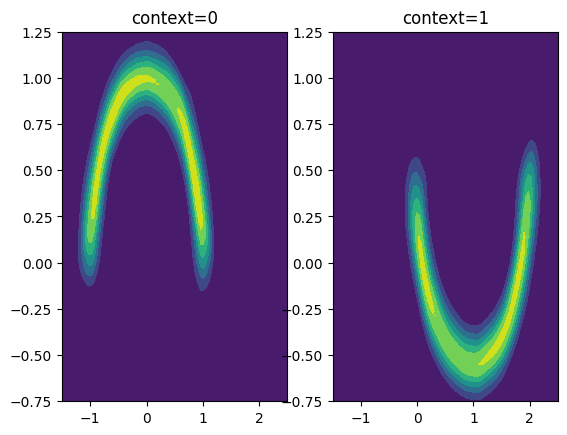

In [68]:
plot_density_on_grid(flow)

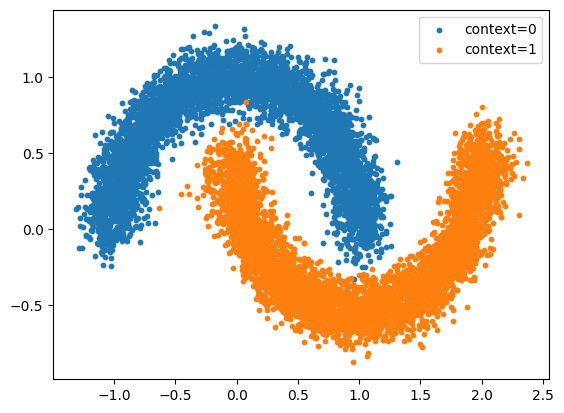

In [66]:
# sample

flow.eval()

with torch.no_grad():
    samples0 = flow.sample(5000, context=torch.zeros(5000, 1).to(device))
    samples1 = flow.sample(5000, context=torch.ones(5000, 1).to(device))

plt.scatter(samples0[:, 0].cpu().numpy(), samples0[:, 1].cpu().numpy(), s=10, label='context=0')
plt.scatter(samples1[:, 0].cpu().numpy(), samples1[:, 1].cpu().numpy(), s=10, label='context=1')
plt.legend()